# Sample normal distribution with Metropolis-Hastings MCMC

In [1]:
from jax import jit, hessian
import jax.numpy as jnp
import jax.random as jr
from jax.scipy.stats import multivariate_normal

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as scipy_mv
from functools import partial

from emcee.autocorr import integrated_time
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

In [2]:
# load samplers
import sys
import os

cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from samplers.mh_mcmc import MH_MCMC

In [3]:
# multivariate normal distribution
ndim = 8
mean = jr.uniform(jr.key(0), (ndim,), minval=-5, maxval=5.)
normals = jr.normal(jr.key(1), (ndim,))
cov = jnp.outer(normals, normals) + jnp.eye(ndim) * 0.1
@jit
def ln_pdf(x):
    return multivariate_normal.logpdf(x, mean=mean, cov=cov)

In [4]:
# Gaussian jump proposal
@jit
def Gaussian_jump(x, i):
    direction_key, weight_key = jr.split(jr.key(i))
    direction = jr.choice(direction_key, x.shape[0])
    jump = jr.normal(weight_key)
    x_copy = x.copy()
    x_copy = x_copy.at[direction].add(jump)
    return x_copy

In [5]:
samples, lnpdf_vals = MH_MCMC(num_samples=int(1e6),
                              ln_pdf_func=ln_pdf,
                              x0=np.zeros(ndim),
                              x_mins=np.ones(ndim) * (-100.),
                              x_maxs=np.ones(ndim) * 100.,
                              jump_proposals_and_weights=[[Gaussian_jump, 5]],
                              Fisher_jump_weight=20,
                              DE_jump_weight=20
                              )

jump proposal acceptance rates 

Gaussian_jump: 0.38556250620593785
Fisher_proposal: 0.9628895662051669
DE_proposal: 0.4678839454585936


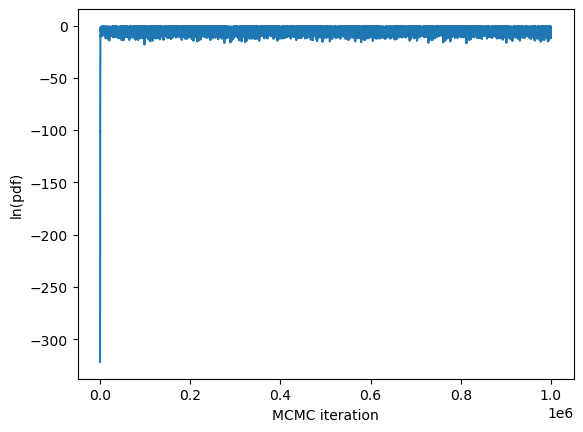

In [6]:
# plot pdf values over sampling
plt.plot(lnpdf_vals)
plt.xlabel('MCMC iteration')
plt.ylabel('ln(pdf)')
plt.show()

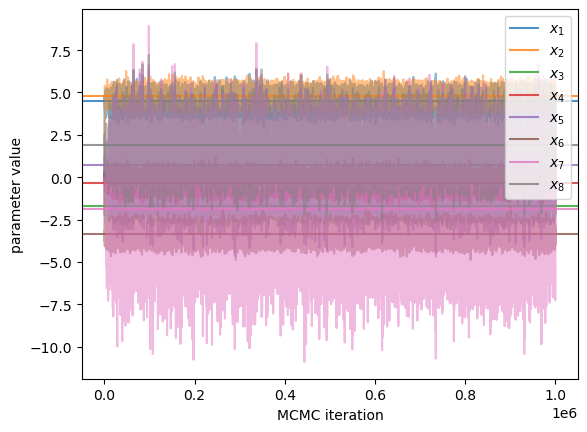

In [7]:
# trace plot
x_labels = [rf'$x_{{{i + 1}}}$' for i in range(ndim)]
for i in range(samples.shape[1]):
    plt.plot(samples[:, i], color=f'C{i}', alpha=0.5)
    plt.axhline(mean[i], color=f'C{i}', alpha=0.8, label=x_labels[i])
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend(loc='upper right')
plt.show()

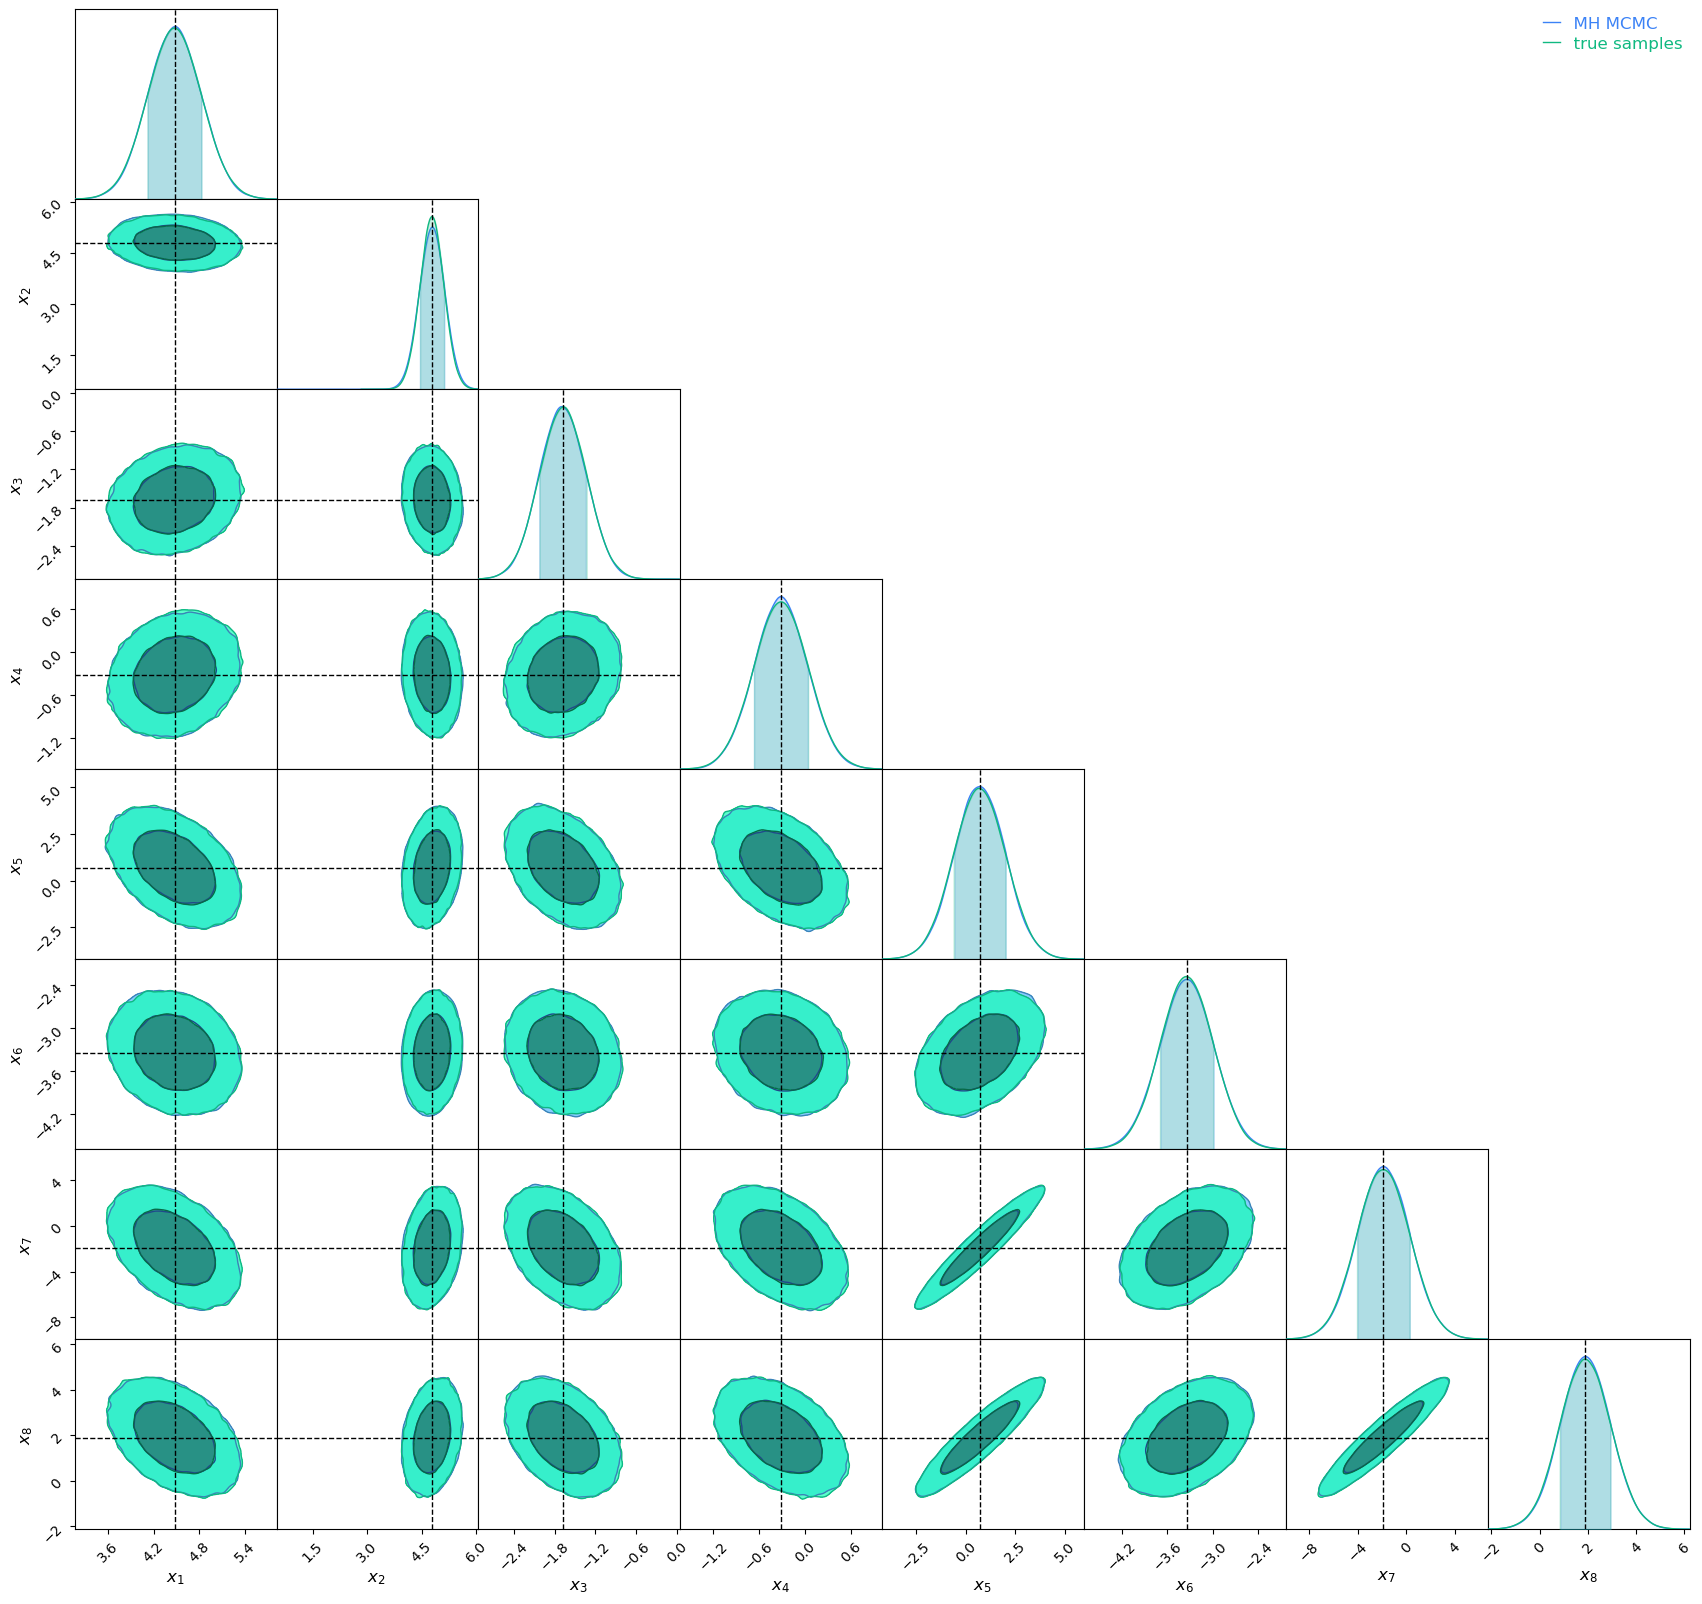

In [8]:
# corner plot
df = pd.DataFrame(samples, columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='MH MCMC'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, mean)}))

# plot true distribution
mv_samples = scipy_mv.rvs(mean=mean, cov=cov, size=100_000)
df_true = pd.DataFrame(mv_samples, columns=x_labels)
c.add_chain(Chain(samples=df_true, name='true samples'))
fig = c.plotter.plot()